<a href="https://colab.research.google.com/github/Arohrba5/Synthetic-Control-Causal-Inference-with-Covid-Data/blob/main/MITx_IDS_S24x_SyntheticInterventionRecitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Data Loading

In [2]:
# Define GitHub raw URLs for your data files
data_file_url_1 = "https://raw.githubusercontent.com/Arohrba5/Synthetic-Control-Causal-Inference-with-Covid-Data/main/data_global_data.csv"
data_file_url_2 = "https://raw.githubusercontent.com/Arohrba5/Synthetic-Control-Causal-Inference-with-Covid-Data/main/data_global_mobility_report.csv"

# Load the data into pandas DataFrames
covid_df = pd.read_csv(data_file_url_1)
mobility_df = pd.read_csv(data_file_url_2)

# Display the first few rows of each dataset
print(covid_df.head())
print(mobility_df.head())

       country      date  deaths  daily_deaths
0  Afghanistan  01/23/20       0           0.0
1  Afghanistan  01/24/20       0           0.0
2  Afghanistan  01/25/20       0           0.0
3  Afghanistan  01/26/20       0           0.0
4  Afghanistan  01/27/20       0           0.0
  country_region_code        country_region  sub_region_1  sub_region_2  \
0                  AE  United Arab Emirates           NaN           NaN   
1                  AE  United Arab Emirates           NaN           NaN   
2                  AE  United Arab Emirates           NaN           NaN   
3                  AE  United Arab Emirates           NaN           NaN   
4                  AE  United Arab Emirates           NaN           NaN   

  metro_area  iso_3166_2_code  census_fips_code                     place_id  \
0        NaN              NaN               NaN  ChIJvRKrsd9IXj4RpwoIwFYv0zM   
1        NaN              NaN               NaN  ChIJvRKrsd9IXj4RpwoIwFYv0zM   
2        NaN              N

Data Preprocessing - Covid Data

In [3]:
# Examine covid dataset
print(covid_df.head())

       country      date  deaths  daily_deaths
0  Afghanistan  01/23/20       0           0.0
1  Afghanistan  01/24/20       0           0.0
2  Afghanistan  01/25/20       0           0.0
3  Afghanistan  01/26/20       0           0.0
4  Afghanistan  01/27/20       0           0.0


In [4]:
# Examine US rows of covid dataset
print(covid_df[covid_df['country'] == 'US'].head(5))

       country      date  deaths  daily_deaths
201996      US  01/23/20       0           0.0
201997      US  01/24/20       0           0.0
201998      US  01/25/20       0           0.0
201999      US  01/26/20       0           0.0
202000      US  01/27/20       0           0.0


In [5]:
# Convert dates into datatime object
covid_df['date'] = pd.to_datetime(covid_df['date'])
print(covid_df.head())

<ipython-input-5-162c1d57a26a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  covid_df['date'] = pd.to_datetime(covid_df['date'])


       country       date  deaths  daily_deaths
0  Afghanistan 2020-01-23       0           0.0
1  Afghanistan 2020-01-24       0           0.0
2  Afghanistan 2020-01-25       0           0.0
3  Afghanistan 2020-01-26       0           0.0
4  Afghanistan 2020-01-27       0           0.0


In [6]:
# Convert US to United States, to match other dataset
covid_df = covid_df.map(lambda x: "United States" if x == 'US' else x)
print(covid_df.loc[201996:202000])

              country       date  deaths  daily_deaths
201996  United States 2020-01-23       0           0.0
201997  United States 2020-01-24       0           0.0
201998  United States 2020-01-25       0           0.0
201999  United States 2020-01-26       0           0.0
202000  United States 2020-01-27       0           0.0


In [7]:
# Establish time steps relative to determine t = 0 for each country (i.e., when country reaches 80 cumulative deaths)

pre_intervention_cum_deaths = 80
covid_df['post-intervention'] = covid_df['deaths'] >= pre_intervention_cum_deaths
covid_df.head()

,country,date,deaths,daily_deaths,post-intervention
0,Afghanistan,2020-01-23,0,0.0,False
1,Afghanistan,2020-01-24,0,0.0,False
2,Afghanistan,2020-01-25,0,0.0,False
3,Afghanistan,2020-01-26,0,0.0,False
4,Afghanistan,2020-01-27,0,0.0,False


In [8]:
# Identify t=0 for each country
t0_date = covid_df[covid_df['post-intervention']].groupby('country')['date'].min()
t0_date

,date
country,
Afghanistan,2020-05-06
Albania,2020-07-07
Algeria,2020-04-02
Andorra,2020-12-18
Angola,2020-08-11
...,...
Vietnam,2021-06-29
West Bank and Gaza,2020-07-29
Yemen,2020-05-31


In [9]:
# Match T=0 date to each country
covid_df = pd.merge(covid_df, t0_date.reset_index(), on='country', how='left').rename(columns={'date_x':'date', 'date_y':'t0_date'})

In [10]:
# Calculate the difference between the T=0 date and the existing date, to figure out the time step of each date (e.g., T=-5)
covid_df['t'] = (covid_df['date'] - covid_df['t0_date']).dt.days

In [11]:
# Only need data for T = -20 to 20
covid_df = covid_df[(covid_df['t'] >= -20) & (covid_df['t'] <= 20)]
covid_df.head()

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0


Data Preprocessing - Mobility Data

In [12]:
# We need to assign mobility reductions each each country's time step.
# Assume that mobility reductions impact future mortality cases with a lag of 20 days.

In [13]:
# Examine data frame
mobility_df.head()


,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [14]:
# Only include country level data (i.e., only include rows with null sub_regions and metro areas)
mobility_df = mobility_df[mobility_df['sub_region_1'].isnull() &
                          mobility_df['sub_region_2'].isnull() &
                          mobility_df['metro_area'].isnull()]
mobility_df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [15]:
# Rename country_region to country
mobility_df = mobility_df.rename(columns={'country_region' : 'country'})

In [16]:
# Make sure data is in date time format
mobility_df['date'] = pd.to_datetime(mobility_df['date'])

In [17]:
# Match covid data to mobility scores on data only for dates that matter (t is between -20 and 20)
# Note: I don't entirely understand this step. Seems like the matcing mobility score to covid data would have made more sense.
mobility_df = pd.merge(mobility_df, covid_df[covid_df['t'] < 0], on=['country', 'date'], how='right')

In [18]:
# Check the t dates fall within the correct range.
mobility_df[['country', 'date', 't', 'retail_and_recreation_percent_change_from_baseline']].head()


,country,date,t,retail_and_recreation_percent_change_from_baseline
0,Afghanistan,2020-04-16,-20.0,-46.0
1,Afghanistan,2020-04-17,-19.0,-41.0
2,Afghanistan,2020-04-18,-18.0,-43.0
3,Afghanistan,2020-04-19,-17.0,-43.0
4,Afghanistan,2020-04-20,-16.0,-42.0


In [19]:
# Group countries by score. Low, moderate, or severe.
country_mobility_scores = mobility_df.groupby('country')['retail_and_recreation_percent_change_from_baseline'].mean()

low_countries = []
moderate_countries = []
severe_countries = []

# Note: Check score is not null to remove countries that exist in mobility data but not in covid data

for country, score in country_mobility_scores.items():
  if(not pd.isnull(score)):
    if(score > -10):
      low_countries.append(country)
    elif (score > -40):
      moderate_countries.append(country)
    else:
      severe_countries.append(country)

len(low_countries), len(moderate_countries), len(severe_countries)

(23, 50, 50)

Shape data

In [20]:
covid_df.head()

,country,date,deaths,daily_deaths,post-intervention,t0_date,t
84,Afghanistan,2020-04-16,29,4.0,False,2020-05-06,-20.0
85,Afghanistan,2020-04-17,30,1.0,False,2020-05-06,-19.0
86,Afghanistan,2020-04-18,30,0.0,False,2020-05-06,-18.0
87,Afghanistan,2020-04-19,30,0.0,False,2020-05-06,-17.0
88,Afghanistan,2020-04-20,33,3.0,False,2020-05-06,-16.0


In [21]:
# Reshape data frame into country rows and t columns and daily_death values
covid_df = covid_df[['country', 'daily_deaths', 't']].pivot(index='country', columns='t', values='daily_deaths').reset_index()

In [22]:
covid_df.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
0,Afghanistan,4.0,1.0,0.0,0.0,3.0,3.0,0.0,4.0,0.0,...,1.0,4.0,4.0,10.0,6.0,12.0,10.0,7.0,1.0,1.0
1,Albania,1.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2.0,...,4.0,1.0,1.0,4.0,3.0,3.0,5.0,6.0,4.0,6.0
2,Algeria,1.0,1.0,1.0,0.0,0.0,3.0,2.0,2.0,4.0,...,20.0,13.0,10.0,12.0,16.0,3.0,8.0,9.0,8.0,10.0
3,Andorra,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0


Modeling - Synthetic Interventions - Moderate Intervention

In [23]:
# Confirm United States is classified as low mobility intervention
country_of_interest = 'United States'
print(country_of_interest in low_countries)

True


In [24]:
# We want to see what the United States would look like if they had implemented a moderate or severe intervention policy.
# Using the Synthetic Intervention Algorithm, we will construct a synthetic counterfactual for comparison.

# To create a synthetic counterfacutual we need to:
# 1. Isolate moderate mobility restriction countries
# 2. Denoise with Hard Singuar Value Thresholding (HSVT)
# 3. Learn a pre-intervention model of the US based on moderate countries
# 4. Apply the model to US post-intervetion

In [25]:
# 1. Isolate moderate mobility restriction countries
moderate_countries_ts = covid_df[covid_df['country'].isin(moderate_countries)]
moderate_countries_ts.head()

t,country,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
4,Angola,3.0,0.0,2.0,4.0,1.0,1.0,6.0,1.0,3.0,...,0.0,2.0,4.0,2.0,1.0,2.0,1.0,1.0,0.0,1.0
12,Bahrain,1.0,2.0,2.0,3.0,2.0,1.0,5.0,4.0,1.0,...,5.0,1.0,0.0,4.0,1.0,2.0,6.0,4.0,3.0,0.0
15,Belarus,3.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,2.0,...,5.0,4.0,7.0,4.0,5.0,5.0,4.0,5.0,6.0,4.0
16,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,132.0,140.0,164.0,185.0,403.0,205.0,283.0,496.0,327.0,254.0
17,Belize,2.0,2.0,0.0,1.0,1.0,0.0,6.0,1.0,0.0,...,5.0,4.0,2.0,10.0,3.0,3.0,1.0,0.0,0.0,16.0


In [32]:
# 2. Denoise with Hard Singuar Value Thresholding (HSVT)
Y_pre = moderate_countries_ts.loc[:,-20:-1].to_numpy()

u, s, vh = np.linalg.svd(Y_pre)
r_tilde = 3
smat = np.zeros((u.shape[0], vh.shape[0]))
smat[:r_tilde, :r_tilde] = np.diag(s[:r_tilde])

Y_pre_tilde = u @ smat @ vh

In [36]:
# 3. Learn a pre-intervention model of the US based on moderate countries
import statsmodels.api as sm

# Dependent varibale is the time series observations before any interventions take place
us_pre = covid_df[covid_df['country'] == "United States"].loc[:, -20: -1].to_numpy().flatten()
dvs = us_pre

# Build model with independent variables from preintervention entries of the denoised matrix
ivs = Y_pre_tilde.T
mod = sm.OLS(dvs, ivs)

res = mod.fit()

In [38]:
# 4. Apply the model to US post-intervetion
Y_post = moderate_countries_ts.loc[:, 0:20].to_numpy()
moderate_counteractual_estimates = res.predict(Y_post.T)

# True values for comparison later
us_post = covid_df[covid_df['country'] == 'United States'].loc[:, 0:20].to_numpy().flatten()

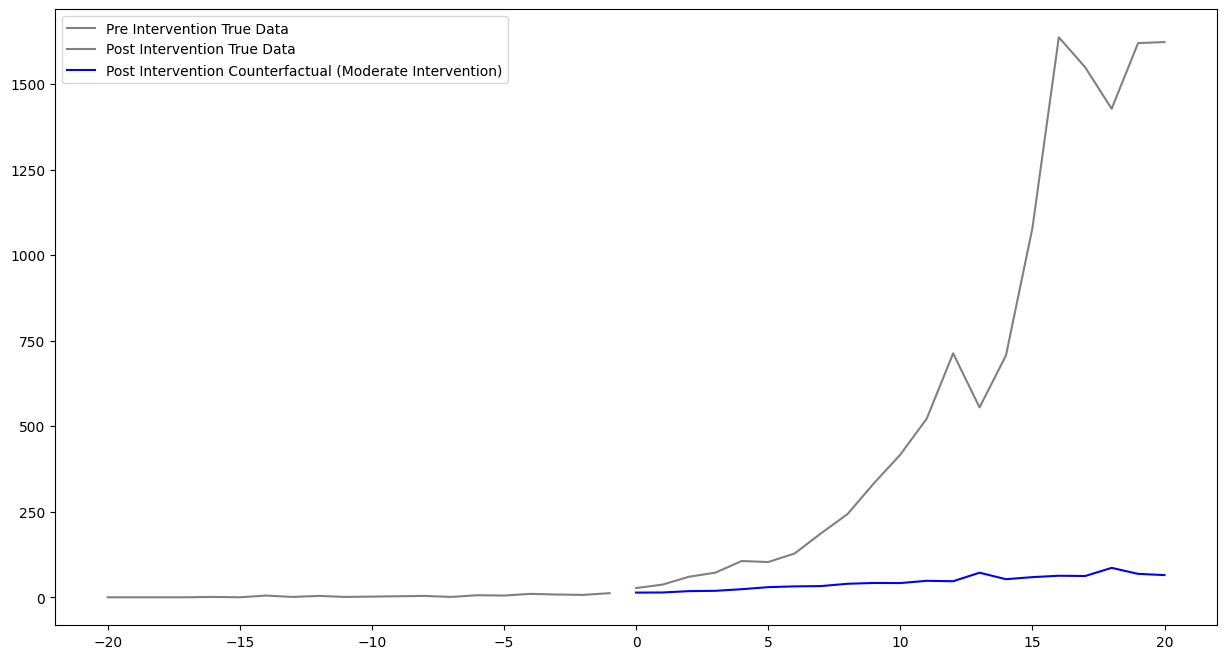

In [41]:
# Plot US post intervention true data versus counterfactual data.
# We would expect post intervention counterfactual under moderate interventions to lead to lower mortality
plt.figure(figsize = (15, 8))

plt.plot(range(-20,0), us_pre, label="Pre Intervention True Data", color='grey')

plt.plot(range(0,21), us_post, label="Post Intervention True Data", color='grey')

plt.plot(range(0,21), moderate_counteractual_estimates, label="Post Intervention Counterfactual (Moderate Intervention)", color='blue')

plt.legend()


Note: Selecting r for synthetic interventions

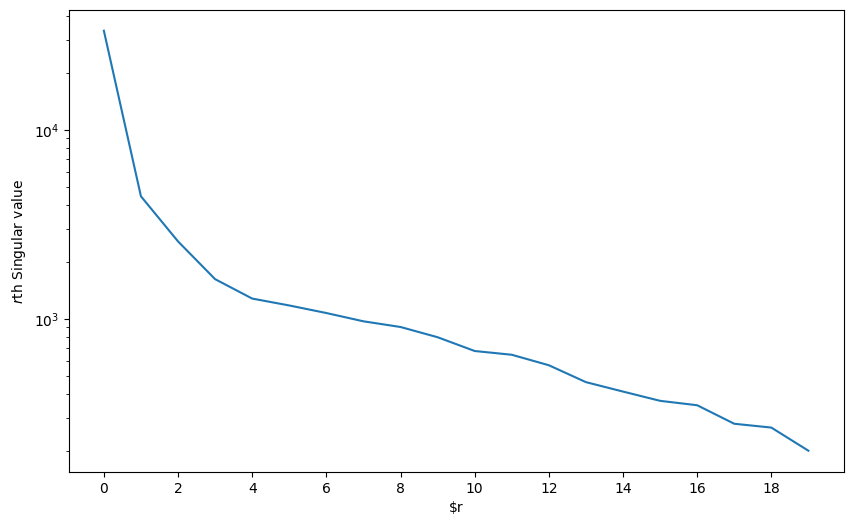

In [43]:
# To identify the number of singular values (r), calculate low rank structure.
# Plot of singular values helps us see if data is low rank
# Also, identification of "elbow point" helps us determine the best r
u, s, vh = np.linalg.svd(covid_df.dropna().loc[:, -20:-1].to_numpy())
plt.figure(figsize=(10,6))
plt.plot(np.power(s, 2))
# plt.semilogy()
plt.xlabel("$r")
plt.ylabel("$r$th Singular value")
plt.xticks(np.arange(0, 20, 2))
plt.show()